참고: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

In [127]:
import librosa
import librosa.display
import os

In [21]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [125]:
filename = './Training_WFDB/A0001.mat'
x = loadmat(filename)

In [137]:
new_file = filename.replace('.mat','.hea')
input_header_file = os.path.join(new_file)
with open(input_header_file,'r') as f:
    header_data=f.readlines()

In [10]:
x

{'val': array([[  28,   39,   45, ...,  258,  259,  259],
        [   7,   11,   15, ...,  248,  249,  250],
        [ -21,  -28,  -30, ...,  -10,  -10,   -9],
        ...,
        [-112, -110, -108, ...,  194,  194,  195],
        [-596, -590, -582, ...,  307,  307,  307],
        [ -16,   -7,    2, ...,  213,  214,  214]], dtype=int16)}

In [138]:
header_data

['A0001 12 500 7500 16-Mar-2020 19:07:01\n',
 'A0001.mat 16+24 1000/mV 16 0 28 -1716 0 I\n',
 'A0001.mat 16+24 1000/mV 16 0 7 2029 0 II\n',
 'A0001.mat 16+24 1000/mV 16 0 -21 3745 0 III\n',
 'A0001.mat 16+24 1000/mV 16 0 -17 3680 0 aVR\n',
 'A0001.mat 16+24 1000/mV 16 0 24 -2664 0 aVL\n',
 'A0001.mat 16+24 1000/mV 16 0 -7 -1499 0 aVF\n',
 'A0001.mat 16+24 1000/mV 16 0 -290 390 0 V1\n',
 'A0001.mat 16+24 1000/mV 16 0 -204 157 0 V2\n',
 'A0001.mat 16+24 1000/mV 16 0 -96 -2555 0 V3\n',
 'A0001.mat 16+24 1000/mV 16 0 -112 49 0 V4\n',
 'A0001.mat 16+24 1000/mV 16 0 -596 -321 0 V5\n',
 'A0001.mat 16+24 1000/mV 16 0 -16 -3112 0 V6\n',
 '#Age: 74\n',
 '#Sex: Male\n',
 '#Dx: RBBB\n',
 '#Rx: Unknown\n',
 '#Hx: Unknown\n',
 '#Sx: Unknown\n']

In [139]:
def get_12ECG_features(data, header_data):
    tmp_hea = header_data[0].split(' ')
    ptID = tmp_hea[0]
    num_leads = int(tmp_hea[1])
    sample_Fs= int(tmp_hea[2])
    gain_lead = np.zeros(num_leads)
    for ii in range(num_leads):
        tmp_hea = header_data[ii+1].split(' ') # +1인 이유는 첫 행을 빼야하니
        gain_lead[ii] = int(tmp_hea[2].split('/')[0]) # 아마도 모든 행을 1000mV로 채울듯

    for iline in header_data:
        if iline.startswith('#Age'):
            tmp_age = iline.split(': ')[1].strip()
            age = int(tmp_age if tmp_age != 'NaN' else 57)
        elif iline.startswith('#Sex'):
            tmp_sex = iline.split(': ')[1]
            if tmp_sex.strip()=='Female':
                sex =1
            else:
                sex=0
        elif iline.startswith('#Dx'):
            label = iline.split(': ')[1].split(',')[0]
    return ptID, num_leads, sample_Fs, gain_lead, age, sex, label

In [141]:
ptID, num_leads, sample_Fs, gain_lead, age, sex, label = get_12ECG_features(data, header_data)

In [143]:
ptID, num_leads, sample_Fs, gain_lead, age, sex, label

('A0001',
 12,
 500,
 array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000.]),
 74,
 0,
 'RBBB\n')

In [12]:
data = np.asarray(x['val'], dtype=np.float64)

In [13]:
data

array([[  28.,   39.,   45., ...,  258.,  259.,  259.],
       [   7.,   11.,   15., ...,  248.,  249.,  250.],
       [ -21.,  -28.,  -30., ...,  -10.,  -10.,   -9.],
       ...,
       [-112., -110., -108., ...,  194.,  194.,  195.],
       [-596., -590., -582., ...,  307.,  307.,  307.],
       [ -16.,   -7.,    2., ...,  213.,  214.,  214.]])

In [14]:
np.shape(data)

(12, 7500)

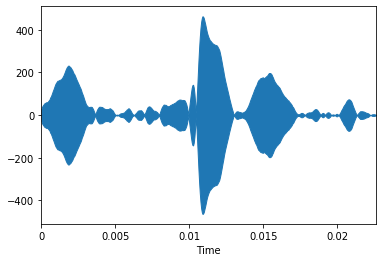

In [81]:
librosa.display.waveplot(data[0,:500])

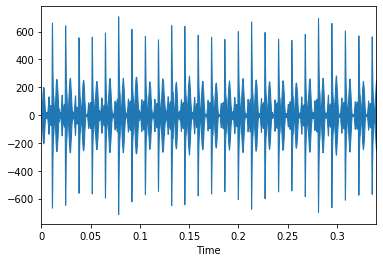

In [17]:
librosa.display.waveplot(data[1])

### Applying the Fourier Transform

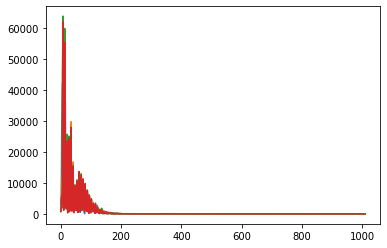

In [26]:
n_fft = 2018
D = np.abs(librosa.stft(data[0], n_fft = n_fft, hop_length = n_fft+1))
plt.plot(D)

#### Transform y-axis (frequency) to log-scale and the amplitude to Decibels

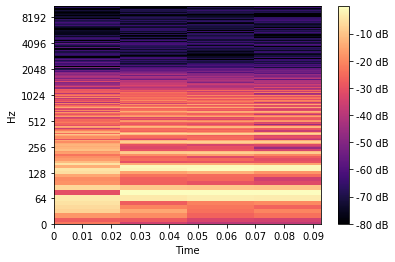

In [28]:
hop_length = 512
sr = 500
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, hop_length=hop_length,
                         x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

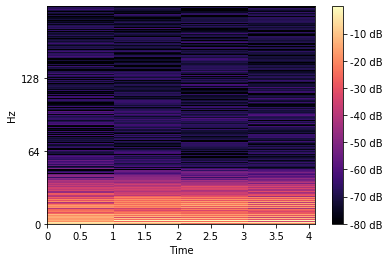

In [30]:
hop_length = 512
sr = 500
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, hop_length=hop_length, sr = sr,
                         x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

### The Mel Spectrogram

In [169]:
n_mels = 128
frame_length = 0.025 # 1초를 40개로?
hop_length = 512
#hop_length = 512 -> 얘가 x축 bin 결정
#input_nfft = int(round(sr*frame_length))
n_fft = 1024
sr = 500
def plt_Mel(data, sr, n_fft, hop_length, n_mels):
    S = librosa.feature.melspectrogram(data, sr=sr, n_fft=n_fft, 
                                       hop_length=hop_length, 
                                       n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
    x_axis='time', y_axis='mel');
    plt.colorbar(format='%+2.0f dB');
    #return S, S_DB

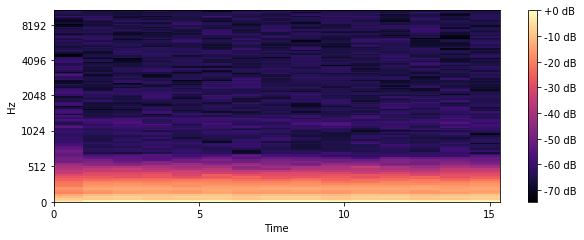

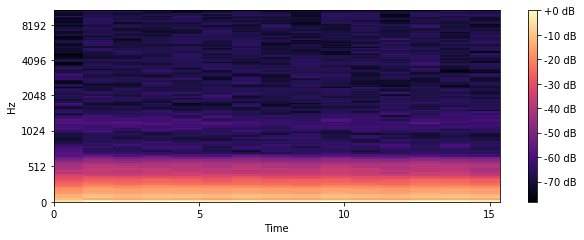

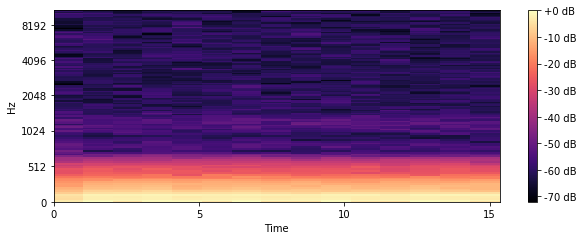

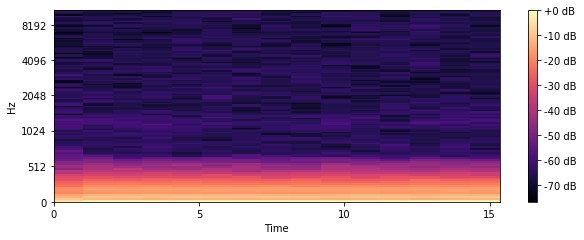

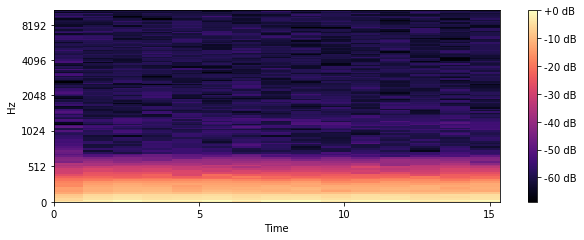

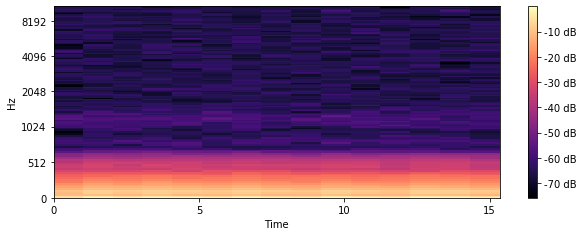

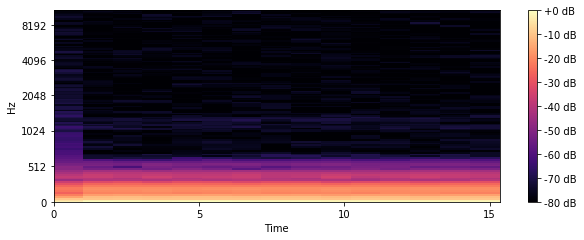

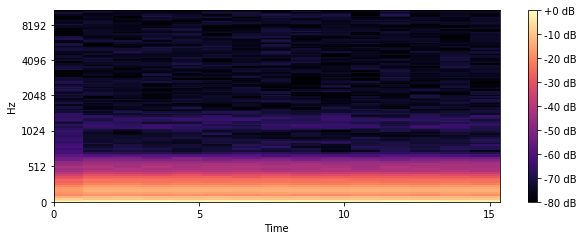

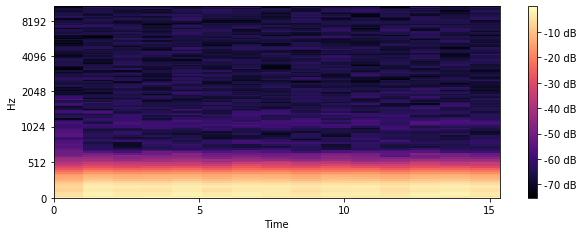

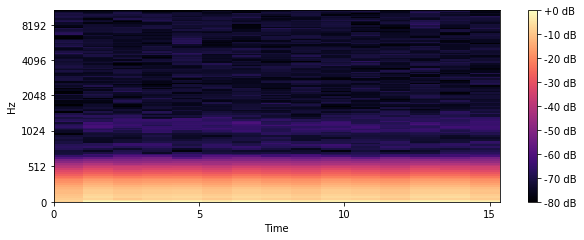

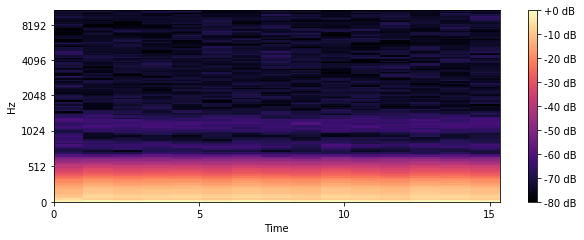

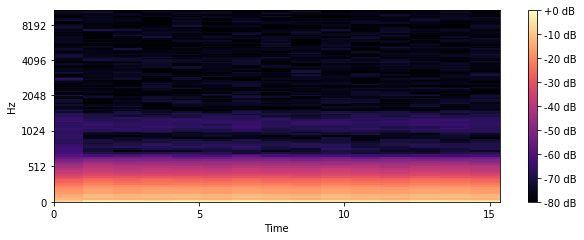

In [170]:
%matplotlib inline
for i in range(num_leads):
    plt.figure(figsize=(10,50))
    plt.subplot(num_leads, 1, i+1)
    plt_Mel(data[i], sr, n_fft, hop_length, n_mels)
    plt.show()
    #plt.tight_layout()

    

In [171]:
M = np.float32([[1, -np.sin(.1), 0], [0, np.cos(.1), 0]])
M

array([[ 1.        , -0.09983341,  0.        ],
       [ 0.        ,  0.9950042 ,  0.        ]], dtype=float32)